# Data cleaning, so we can build a classifiier

### **Note:** Remember to check which environment this notebook is using!

## Steps in this notebook
1. Get the packages we need (install -> import)
2. `emnist` pulls a clean dataset of handwritten characters
    1. Clean dataframes are `raw_train` and `raw_test`
    2. Each has only two columns
        1. 'image' - 28x28 pixel array images of handwritten characters
        2. 'label' - different number for class of digit: 0 -> 0, 10 -> A, 61 -> z
3. Demonstrate basic plotting of the images
4. Intentionally dirty this clean dataset
    1. Dirty dataframes are `dirty_train` and `dirty_test`
    2. Look through how the dirtying process works for ideas on how to clean up
5. Space for whatever you're going to do next
    1. Get cleaning with pandas
    2. Build classifiers with the data you've cleaned
    3. Skip data cleaning and build classifier with the raw data

In [1]:
# Install packages

# Uncomment the followinig lines the first time running this notebook in this environment
# %conda install pandas numpy emnist matplotlib
# %pip install emnist

In [2]:
# Import packages
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emnist
from hashlib import sha1

In [3]:
# Load the data, and reshape it into a 28x28 array

# The size of each image is 28x28 pixels
size = 28 

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
raw_train = pd.DataFrame()

# Add a column showing the label
raw_train['label'] = label

# Add a column with the image data as a 28x28 array
raw_train['image'] = list(image)


# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
raw_test = pd.DataFrame()
raw_test['label'] = label
raw_test['image'] = list(image)


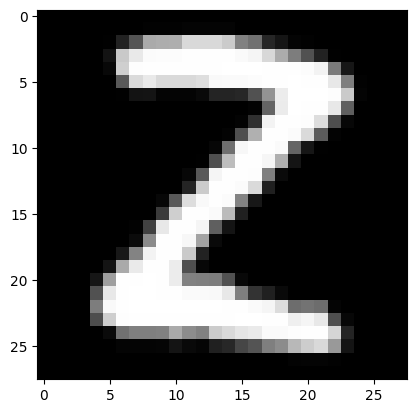

In [4]:
# We can plot individual images using matplotlib
plt.imshow(raw_train['image'][0], cmap='gray')
plt.show() # Show the plot (optional with a single image)

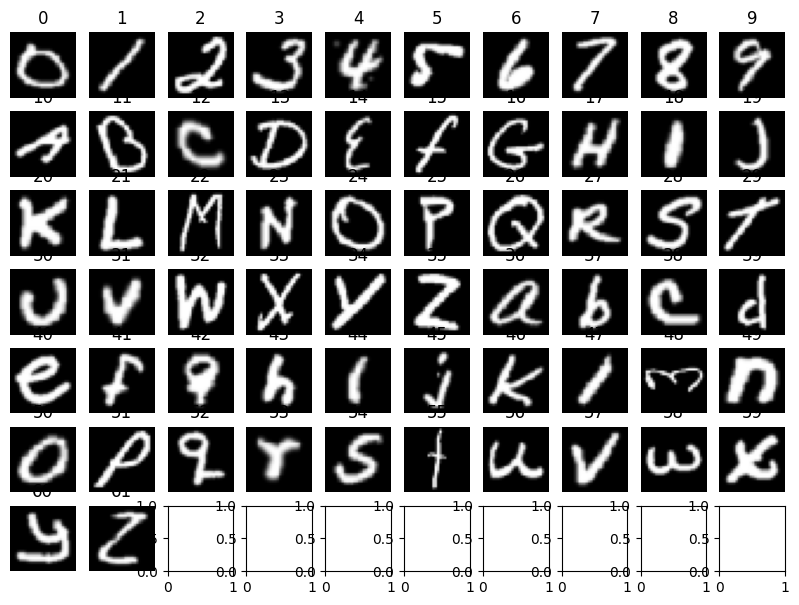

In [5]:
# Get the first row for each label
firsts = raw_train.groupby('label').first().reset_index()

# Build a plot with the first image for each label
fig, ax = plt.subplots(7, 10, figsize=(10, 7))
for i in range(62):
    ax[i//10, i%10].imshow(firsts['image'][i], cmap='gray')
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title(firsts['label'][i])

# Getting dirty

Now that we've got the data in good shape, let's rough it up a little.

- [x] Add `predicit` col with confidence probabilities from a previous model
- [x] Numerical:
    - [x] outlier
    - [x] out-of-bounds
- [x] Labels: missing(Null, None, "", " "), name that number, double-struck
- [x] Image: zeroed, null? dimensions?
- [x] Image: add noise
- [x] Image: flip horizonally
- [x] Duplicated rows

In [6]:
# Now let's mess up the data a bit

# Percent of the time something dirty happens (0.1%) for each method
pct = 0.001 

# Copy the splits into new dataframes to mess up
dirty_train = raw_train.copy()
dirty_test  = raw_test.copy()

# Add a column for a hash of the images (should make it easier to compare them)
dirty_train['image_hash'] = dirty_train['image'].apply(lambda x: sha1(x.tobytes()).hexdigest())
dirty_test['image_hash']  =  dirty_test['image'].apply(lambda x: sha1(x.tobytes()).hexdigest())

# For each row, 0.1% of the time, duplicate the row
dirty_train = pd.concat([dirty_train, dirty_train.sample(frac=pct)])
dirty_test  = pd.concat([dirty_test,   dirty_test.sample(frac=pct)])

# For each row, 0.1% of the time, zero out the image array
dirty_train['image'] = dirty_train['image'].apply(lambda x: np.zeros((size, size)) if np.random.rand() < pct else x)
dirty_test['image']  =  dirty_test['image'].apply(lambda x: np.zeros((size, size)) if np.random.rand() < pct else x)

# Add a column for classification scores from a previous model
dirty_train['predict'] = np.random.normal(0.75, 0.1, dirty_train.shape[0])
dirty_test['predict']  = np.random.normal(0.75, 0.1, dirty_test.shape[0])

# For each row, 0.1% of the time, replace the predict column with a normal distribution centered on 0.25
dirty_train['predict'] = dirty_train['predict'].apply(lambda x: np.random.normal(0.25, 0.1) if np.random.rand() < pct else x)
dirty_test['predict']  =  dirty_test['predict'].apply(lambda x: np.random.normal(0.25, 0.1) if np.random.rand() < pct else x)

# For each row, 0.1% of the time, add/subtract 1 to the predict column
dirty_train['predict'] = dirty_train['predict'].apply(lambda x: x + 1 if np.random.rand() < pct/2 else x)
dirty_test['predict']  =  dirty_test['predict'].apply(lambda x: x + 1 if np.random.rand() < pct/2 else x)
dirty_train['predict'] = dirty_train['predict'].apply(lambda x: x - 1 if np.random.rand() < pct/2 else x)
dirty_test['predict']  =  dirty_test['predict'].apply(lambda x: x - 1 if np.random.rand() < pct/2 else x)

# For each row, 0.1% of the time, choose a column at random and set it to NaN
dirty_train = dirty_train.apply(lambda row: row if np.random.rand() > pct else row.apply(lambda x: np.nan if np.random.rand() > 0.5 else x), axis=1)
dirty_test  =  dirty_test.apply(lambda row: row if np.random.rand() > pct else row.apply(lambda x: np.nan if np.random.rand() > 0.5 else x), axis=1)

# Mislabel 0.1% of the data with strings that look like labels or missing values (e.g., names like "one", numbers greater than 62, " ")
# Create a list of bad labels
bad_labels = ['number', 'letter', 'maybe three?', 'think this is a seven', ' ', '', 'NaaN', 'Null'] + list(range(63, 100))
# For 0.1% of the rows, randomly choose a bad label
dirty_train['label'] = dirty_train['label'].apply(lambda x: np.random.choice(bad_labels) if np.random.rand() < pct else x)
dirty_test['label']  =  dirty_test['label'].apply(lambda x: np.random.choice(bad_labels) if np.random.rand() < pct else x)




# TEMPLATE: For each row, PCT% of the time, randomly apply METHOD() to the COLUMN
# df['COLUMN'] = dirty_train['column'].apply(lambda x: METHOD(x) if np.random.rand() < PCT else x)

# Not applying these for now, but they're here if you want to try them

# For each row, randomly decide whether to apply a random noise
# dirty_train['image'] = dirty_train['image'].apply(lambda x: x + np.random.rand(size, size) if np.random.rand() < 0.1 else x)

# For each row, randomly decide whether to flip the image horizontally
#dirty_train['image'] = dirty_train['image'].apply(lambda x: np.flip(x, axis=1) if np.random.rand() < 0.1 else x)


# Next steps

The changes above were applied randomly, so we'll need to find them and make a plan to fix them.

- [ ] Create a column to identify whether each row came from *train* or *test*
- [ ] (optional) Merge the data into a single
- [ ] Explore the data to understand what's in it
- [ ] List potential data issues to fix
    - Duplicate rows
    - Missing values
    - Outliers and out-of-bounds issues
    - Label issues
    - Image issues
    - Zeroed values
- [ ] Create a friendlier column for image labels
- [ ] Recategorizing the labels into 'numbers' and 'letters'
- [ ] Bin the prediction scores of the previous model

In [10]:
# Let's start cleaning!

# Labels! They're hard to understand as numbers, so let's map them to characters
# We can do this by manually creating a dictionary:
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Or generate the list of labels using the following code:
# create the characters list, which is the digits, then uppercase, then lowercase
chars = string.digits + string.ascii_uppercase + string.ascii_lowercase
# create the dictionary mapping the numbers to the characters
num_to_char = {i: chars[i] for i in range(len(chars))}

# Add a column showing which split (train vs test) each row came from
raw_train['split'] = 'train'
raw_test['split']  = 'test'
dirty_train['split'] = 'train'
dirty_test['split'] = 'test'

# Add a column for a hash of the images (might make it easier to compare them)
dirty_train['image_hash'] = dirty_train['image'].apply(lambda x: sha1(np.ascontiguousarray(x)).hexdigest())
dirty_test['image_hash']  =  dirty_test['image'].apply(lambda x: sha1(np.ascontiguousarray(x)).hexdigest())

In [11]:
merged = pd.concat([dirty_test, dirty_train], axis=0)

In [9]:
merged.duplicated


<bound method DataFrame.duplicated of        label                                              image  \
0       18.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1       36.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2        0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3        3.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4       33.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...      ...                                                ...   
236781  11.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
405394  40.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
119197  47.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
216730  24.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
303570   8.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                      image_hash   predict  
0       3d4e830e01cd8f7ef77adfb3cdfecc0106f44f9a  0.579879  
1       e1038df7a2b42e643c559a183fa